#With Google Colab  

In [1]:
# Google Colab 환경에서 작성
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# FilePath (Google Drive)

In [2]:
%cd drive/MyDrive/인공지능응용

/content/drive/MyDrive/인공지능응용


# Import

In [3]:
import os
import pandas as pd
import numpy as np
import random as python_random

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

# SEED FIX(42)

In [4]:
seed = 42
np.random.seed(seed)
python_random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Data Import

In [5]:
# Train / Test로 사전에 분리된 Data를 Import
train = pd.read_csv('/content/drive/MyDrive/인공지능응용/Dataset/Processed_train_TO.csv')
test = pd.read_csv('/content/drive/MyDrive/인공지능응용/Dataset/Processed_test_TO.csv')

In [6]:
train['Y_Class'].unique()

array([0])

# Data Preprocessing

In [7]:
# Label Encoding
cat_cols = ['PRODUCT_CODE', 'LINE']

for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

# Missing Value
train = train.fillna(0)
test = test.fillna(0)

# Only Normal Data
train_df = train[train['Y_Class']==0]

# Use Anomal, Normal Data
test_df = test.copy()

# Display
train_df

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,0,0.259525,0,1,0.0,0.0,0.0,0.0,-0.833333,0.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,0,0.093516,1,1,0.0,0.2,0.0,0.0,0.500000,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,0,-0.483654,1,1,0.0,-1.6,0.0,0.0,0.500000,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
3,0,0.324136,1,1,0.0,0.0,0.0,0.0,0.166667,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
4,0,0.107118,1,1,0.0,0.0,0.0,0.0,1.833333,0.0,...,0.000007,0.000004,0.190070,0.000031,0.000681,0.000039,0.000004,0.000003,0.188,0.000030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,0,-0.680887,0,1,0.0,1.2,0.0,1.0,-0.833333,0.0,...,0.000006,0.000004,0.190968,0.000009,0.001270,0.000022,0.000004,0.000001,0.190,0.000005
532,0,0.146070,0,0,38.0,-0.2,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
533,0,-0.172347,0,0,152.0,0.4,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
534,0,0.334647,1,0,144.0,-0.2,0.0,0.0,2.833333,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


# Cuda Setting

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# HyperParameter

In [9]:
Epochs = 1700
Batch_size = 32
Learning_rate = 0.01
w1 = 1
w2 = 10
w3 = 1

# DataLoader

In [10]:
class MyDataset(Dataset):
    def __init__(self, df, eval_mode):
        self.df = df
        self.eval_mode = eval_mode
        self.labels = self.df['Y_Class'].values
        self.df = self.df.drop(columns=['Y_Class'])
        self.df = self.df.values

    def __getitem__(self, index):
        if self.eval_mode:
            self.x = self.df[index]
            self.y = self.labels[index]
            return torch.Tensor(self.x), self.y
        else:
            self.x = self.df[index]
            return torch.Tensor(self.x)

    def __len__(self):
        return len(self.df)

In [11]:
train_dataset = MyDataset(df = train_df, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)

test_dataset = MyDataset(df = test_df, eval_mode=True)
test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=False)

# Model : Autoencoder

In [12]:
class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(681, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        z_code = self.encoder(x)
        return z_code

class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, 681),
        )

    def forward(self, x):
        x_hat = self.decoder(x)
        return x_hat


# Loss

In [13]:
def loss_enc(z_code, z_code_hat):
    # L2 loss for encoding
    l_enc = torch.sum((z_code - z_code_hat)**2, dim=(1))
    return l_enc

def loss_rec(x, x_hat):
    # L1 loss for reconstruction
    l_con = torch.sum(torch.abs(x - x_hat), dim=(1))
    return l_con

def loss_autoencoder(z_code, z_code_hat, x, x_hat, w_enc=w1, w_con=w2):
    # Calculate encoding and reconstruction losses
    l_enc = loss_enc(z_code, z_code_hat)
    l_con = loss_rec(x, x_hat)

    # Weighted sum of the two losses
    l_tot = torch.mean((w_enc * l_enc) + (w_con * l_con))

    # Compute mean losses for reporting
    l_enc_mean = torch.mean(l_enc)
    l_con_mean = torch.mean(l_con)

    return l_tot, l_enc_mean, l_con_mean


# Model_Fit

In [14]:
epochs = Epochs

model = Autoencoder().to(device)
model.train()

# 옵티마이저 설정
optimizer = torch.optim.Adam(model.parameters(), lr=Learning_rate)

# 학습률 스케줄러 설정
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=20, threshold_mode='abs', min_lr=1e-8, verbose=True)

encoder_loss_per_epoch = []
decoder_loss_per_epoch = []

for i in range(1, epochs + 1):

    train_loss = []
    encoder_loss = []
    decoder_loss = []
    best_score = 0

    for idx, data in enumerate(train_loader):

        x = data.to(device)

        z_code = model.encoder(x)
        x_hat = model.decoder(z_code)
        z_code_hat = model.encoder(x_hat)

        l_tot, l_enc, l_con = loss_autoencoder(z_code, z_code_hat, x, x_hat)

        optimizer.zero_grad()
        l_tot.backward()
        optimizer.step()

        train_loss.append(l_tot.item())
        encoder_loss.append(l_enc.item())
        decoder_loss.append(l_con.item())

    encoder_loss_per_epoch.append(np.mean(encoder_loss))
    decoder_loss_per_epoch.append(np.mean(decoder_loss))
    print(f'Epoch : [{i}] Train loss : [{np.mean(train_loss)}] Encoder loss : [{np.mean(encoder_loss)}] Decoder loss : [{np.mean(decoder_loss)}]')

    score = np.mean(train_loss)
    scheduler.step(score)

    if best_score < score:
        best_score = score
        torch.save(model.encoder.state_dict(), '/content/drive/MyDrive/인공지능응용/best_full_autoencoder.pth')
        torch.save(model.decoder.state_dict(), '/content/drive/MyDrive/인공지능응용/best_full_autodecoder.pth')


Epoch : [1] Train loss : [95093.99954044117] Encoder loss : [9.45437393468969] Decoder loss : [9508.454474954044]
Epoch : [2] Train loss : [89553.91509650735] Encoder loss : [5.2980137853061455] Decoder loss : [8954.861916934742]
Epoch : [3] Train loss : [86257.10788143383] Encoder loss : [5.693314170136171] Decoder loss : [8625.141472311581]
Epoch : [4] Train loss : [84708.01102941176] Encoder loss : [4.118772934464848] Decoder loss : [8470.38924632353]
Epoch : [5] Train loss : [83725.4864430147] Encoder loss : [1.8491821078693165] Decoder loss : [8372.363669002758]
Epoch : [6] Train loss : [83456.22173713235] Encoder loss : [3.0489769963657154] Decoder loss : [8345.317483340992]
Epoch : [7] Train loss : [83225.64303768383] Encoder loss : [3.987433763111339] Decoder loss : [8322.165627872242]
Epoch : [8] Train loss : [81572.98506433824] Encoder loss : [3.8983651750227986] Decoder loss : [8156.908806295956]
Epoch : [9] Train loss : [80803.02987132352] Encoder loss : [2.274521645377664]

# Loss Visualization

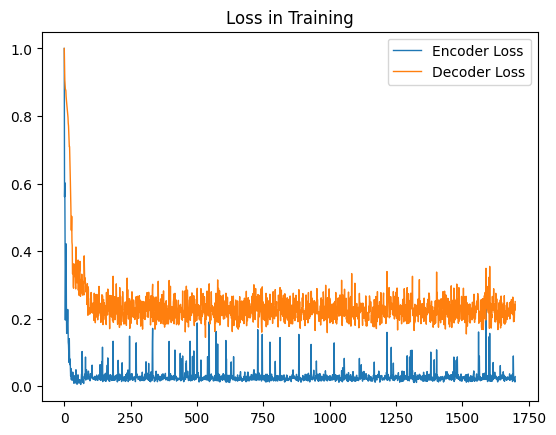

In [15]:
#visualize results

vis_encoder_loss = [x / max(encoder_loss_per_epoch) for x in encoder_loss_per_epoch]
vis_decoder_loss = [x / max(decoder_loss_per_epoch) for x in decoder_loss_per_epoch]


plt.plot(vis_encoder_loss,label='Encoder Loss',linewidth=1.)
plt.plot(vis_decoder_loss,label='Decoder Loss',linewidth=1.)

plt.title('Loss in Training')
plt.legend()
plt.show()

#Model_Load

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder().to(device)
model.encoder.load_state_dict(torch.load('/content/drive/MyDrive/인공지능응용/best_full_autoencoder.pth', map_location=device))
model.decoder.load_state_dict(torch.load('/content/drive/MyDrive/인공지능응용/best_full_autodecoder.pth', map_location=device))
model.encoder.eval()
model.decoder.eval()

Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=512, out_features=681, bias=True)
  )
)

# Model_Eval

In [17]:
def calculate_anomaly_score(x, x_hat):
    return torch.sum(torch.abs(x - x_hat), dim=1)

def feature_scale(anomaly_scores):
    min_score = np.min(anomaly_scores)
    max_score = np.max(anomaly_scores)
    return (anomaly_scores - min_score) / (max_score - min_score)

In [18]:
model.encoder.eval()
model.decoder.eval()
val_anomaly_scores = []

with torch.no_grad():
    for data, label in test_loader:
        data, target = data.to(device), data.cpu()
        # 인코더와 디코더를 통한 데이터의 재구성
        reconstructed_data = model.decoder(model.encoder(data))

        # 이상치 점수 계산
        anomaly_score = calculate_anomaly_score(data, reconstructed_data) # Reconstructed_Error : Anomaly Score
        val_anomaly_scores.extend(anomaly_score.cpu().numpy())

scaled_anomaly_scores = feature_scale(np.array(val_anomaly_scores))

# Anomaly Classification With Threshold

In [19]:
thr = 0.5
pred_GAN = np.where(scaled_anomaly_scores > thr,1,0) # Threshold보다 높은 Anomaly Score를 나타내면 이상치(1)로 분류

# Result

In [20]:
# Confusion Matrix
print(confusion_matrix(test_df['Y_Class'],pred_GAN))

# Clssificaion Report
print(classification_report(test_df['Y_Class'],pred_GAN))

[[92  8]
 [91  9]]
              precision    recall  f1-score   support

           0       0.50      0.92      0.65       100
           1       0.53      0.09      0.15       100

    accuracy                           0.51       200
   macro avg       0.52      0.51      0.40       200
weighted avg       0.52      0.51      0.40       200



# Visualization

## Threshold

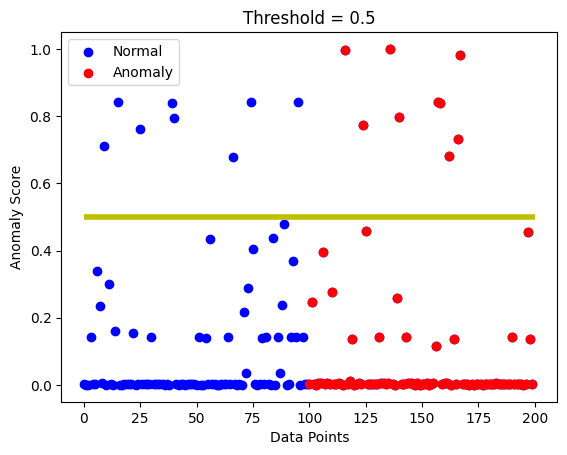

In [21]:
# Visualization

plt.scatter(range(len(scaled_anomaly_scores)), scaled_anomaly_scores, c='b', label='Normal')
plt.scatter(np.array(range(len(scaled_anomaly_scores)))[test_df['Y_Class'] == 1], scaled_anomaly_scores[test_df['Y_Class'] == 1], c='r', label='Anomaly')
plt.hlines(thr, xmin=0, xmax=len(scaled_anomaly_scores), colors='y', linewidth=4)

plt.title(f'Threshold = {thr}')
plt.xlabel('Data Points')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

## Confusion Matrix

accuracy:  0.505
recall:  0.09
precision:  0.529
f1-score:  0.154


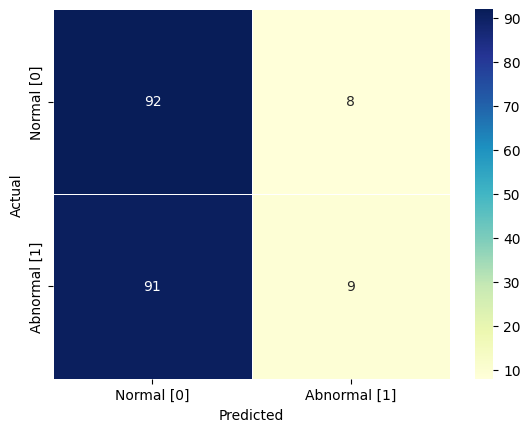

In [22]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

con_mat = confusion_matrix(test_df['Y_Class'].values, pred_GAN)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'],
            yticklabels=['Normal [0]', 'Abnormal [1]'],
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(test_df['Y_Class'].values, pred_GAN))
print("recall: ", round(recall_score(test_df['Y_Class'].values, pred_GAN),3))
print("precision: ", round(precision_score(test_df['Y_Class'].values, pred_GAN),3))
print("f1-score: ", round(f1_score(test_df['Y_Class'].values, pred_GAN),3))

#Anomaly Classification With Kmeans

## Kmeans Visualization

In [23]:
from sklearn.cluster import KMeans

def visualize_kmeans_result(model, data, data_label, name, cluster_colors):
    # 모델 clustering 예측 결과와 실제 label 데이터를 가시화할 2개의 subplot
    n_cols = 2
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 클러스터링 모델로 클러스터링 결과를 저장
    cluster_labels = model.fit_predict(data.reshape(-1, 1)) # 1차원 데이터를 2차원으로 변환

    # 두 군집 중 평균이 더 높은 군집을 찾아 이진 분류 수행
    pred_GAN_K = [1 if cluster_labels[i] == 0 else 0 for i in range(len(cluster_labels))]

    # 데이터프레임 생성
    dataframe = pd.DataFrame({
        'Index': np.arange(len(data)),
        'Value': data,
        'Cluster': pred_GAN_K
    })

    unique_labels = np.unique(pred_GAN_K)

    # 클러스터링 결과값 별로 scatter plot 으로 시각화
    for label in unique_labels:
        label_df = dataframe[dataframe['Cluster'] == label]
        axs[0].scatter(label_df['Index'], label_df['Value'], s=70, edgecolor='k', label='Cluster ' + str(label), color=cluster_colors[label])
    axs[0].set_title(name + ' Cluster Visualization')
    axs[0].legend()

    # 레이블 정보별로 scatter plot을 시각화
    unique_labels = np.unique(data_label)
    label_colors = ['tab:blue', 'tab:green', 'tab:orange']
    for label in unique_labels:
        label_df = dataframe[data_label == label]
        axs[1].scatter(label_df['Index'], label_df['Value'], s=70, edgecolor='k', label=str(label), color=label_colors[label])
    axs[1].set_title(name + ' Label Visualization')
    axs[1].legend()

    plt.show()
    return pred_GAN_K


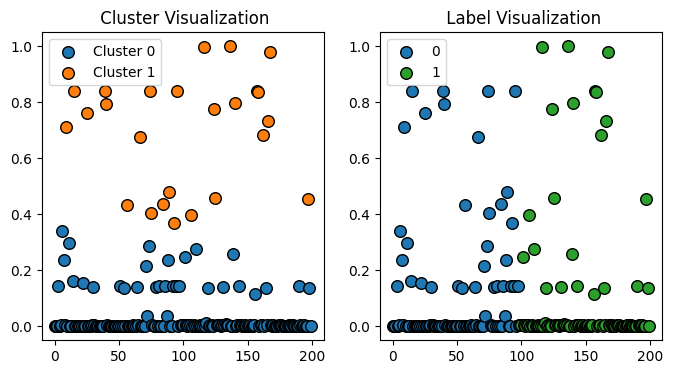

In [24]:
# Classification
cluster_color = ['tab:blue', 'tab:orange']
tuned_model = KMeans(n_clusters=2, init='k-means++', max_iter=100000, n_init=100, random_state=42)
pred_GAN_K = visualize_kmeans_result(tuned_model, scaled_anomaly_scores,test_df['Y_Class'] , '', cluster_color)

## Kmeans Confusion Mat

accuracy:  0.495
recall:  0.12
precision:  0.48
f1-score:  0.192


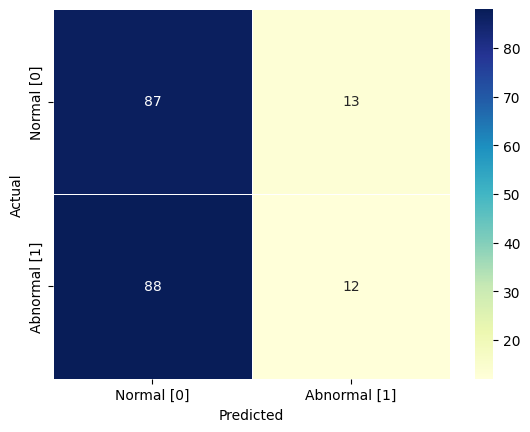

In [25]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

con_mat = confusion_matrix(test_df['Y_Class'].values, pred_GAN_K)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'],
            yticklabels=['Normal [0]', 'Abnormal [1]'],
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(test_df['Y_Class'].values, pred_GAN_K))
print("recall: ", round(recall_score(test_df['Y_Class'].values, pred_GAN_K),3))
print("precision: ", round(precision_score(test_df['Y_Class'].values, pred_GAN_K),3))
print("f1-score: ", round(f1_score(test_df['Y_Class'].values, pred_GAN_K),3))